In [1]:
%matplotlib notebook
import mynn
import mygrad as mg
import numpy as np
import matplotlib as pyplot

In [2]:
from mynn.layers.dense import dense
from mynn.activations.relu import relu
from mynn.initializers.he_normal import he_normal
from mynn.losses.mean_squared_loss import mean_squared_loss
from mynn.optimizers.adam import Adam

In [3]:
data = np.load('data.npy')
# data is a np.ndarray[(np.ndarray, np.ndarray, np.ndarray)]
# [(encoded original, encoded cipher, encoded alphabet)]

In [4]:
def decode_alpha(text, alphabet):
    letter_map = Counter(text)
    letter_map = {num : ch for ch, num in letter_map.items()}

In [5]:
class Model:
    def __init__(self, n):
        """This initializes all of the layers in our model, and sets them
        as attributes of the model.
        
        Parameters
        ----------
        n : int
            The size of our hidden layer
            
        num_out : int
            The size of the output layer (i.e. the number
            of tendrils)."""
        self.dense1 = dense(1000, n, weight_initializer=he_normal)
        self.dense2 = dense(n, n * 2, weight_initializer=he_normal)
        self.dense3 = dense(n * 2, n, weight_initializer=he_normal)
        self.dense4 = dense(n, 26, weight_initializer=he_normal)
        
    def __call__(self, x):
        '''Passes data as input to our model, performing a "forward-pass".
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor], shape=(M, 2)
            A batch of data consisting of M pieces of data,
            each with a dimentionality of 2.
            
        Returns
        -------
        mygrad.Tensor, shape=(M, num_out)
            The model's prediction for each of the M pieces of data.
        '''
        
        # We pass our data through a dense layer, use the activation 
        # function relu and then pass it through our second dense layer
        # We don't have a second activation function because it happens
        # to be included in our loss function: softmax-crossentropy
        first = relu(self.dense1(x))
        second = relu(self.dense2(first))
        third = relu(self.dense3(second))
        return self.dense4(third)
        
    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.
        
        This can be accessed as an attribute, via `model.parameters` 
        
        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model"""
        return self.dense1.parameters + self.dense2.parameters + self.dense3.parameters + self.dense4.parameters

In [82]:
model = Model(4500)
optim = Adam(model.parameters)

<IPython.core.display.Javascript object>


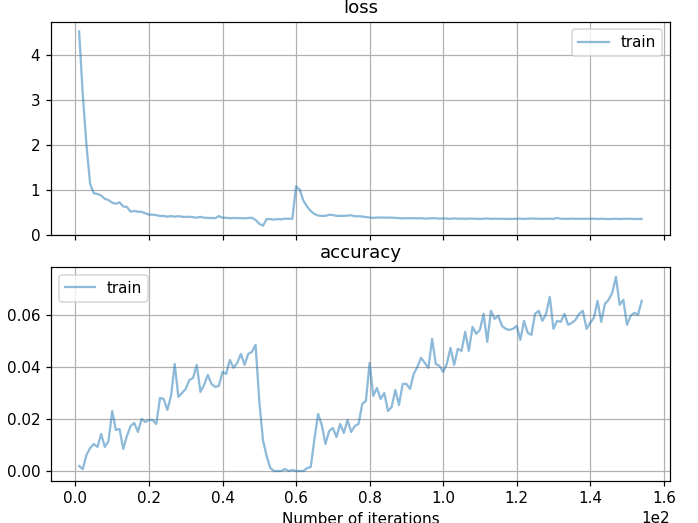

In [88]:
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=("loss", "accuracy"), last_n_batches=1500)

In [64]:
x_train = np.ndarray((10_000, 1_000))
y_train = np.ndarray((10_000, 26))


for i, row in enumerate(data):
    x_train[i] = np.concatenate((row[0][:500], row[1][:500]))
    y_train[i] = row[2].astype(np.float)

x_train /= np.mean(x_train)
print(np.mean(y_train))
y_train /= np.mean(y_train)
print(np.mean(y_train))
y_train -= np.mean(y_train)



12.5
1.0000000000000004


In [84]:
print(y_train.mean())
y_train[0]

-4.311448634006445e-16


array([ 0.36,  1.  ,  0.76,  0.44,  0.2 ,  0.68, -0.52, -0.44, -0.12,
        0.92, -0.92,  0.28, -0.84,  0.6 , -0.36,  0.52,  0.84, -0.04,
       -1.  , -0.68, -0.76, -0.6 ,  0.12,  0.04, -0.28, -0.2 ])

In [ ]:
batch_size = 100

for epoch_cnt in range(50):
    idxs = np.arange(len(data))
    np.random.shuffle(idxs)  
    
    for batch_cnt in range(0, len(data) // batch_size):
        batch_indices = idxs[(batch_cnt * batch_size):((batch_cnt + 1) * batch_size)]
        batch = x_train[batch_indices]
        
        truth = y_train[batch_indices]
        
        pred = model(batch) * 10
        print(pred[0])
        print(truth[0])
        
        loss = mean_squared_loss(pred, truth) - ((pred**2).mean())/4
        accuracy = np.mean(np.abs(pred.data * 10 - truth) <= 1.0/13.0)

        loss.backward()
        optim.step()
        loss.null_gradients()

        plotter.set_train_batch({"loss" : loss.item(), "accuracy" : accuracy}, batch_size)
    plotter.set_train_epoch()

Tensor([2.00511508, 0.36582409, 1.0059876 , 0.52114805, 1.615149  ,
        1.56946379, 1.49198202, 0.69732699, 1.69383142, 1.78240555,
        1.13742616, 0.82078932, 0.60656356, 1.07328615, 1.13497822,
        1.66403859, 1.39678662, 0.74492526, 1.87559897, 1.48396509,
        1.31042595, 0.48301647, 0.79101291, 1.06921713, 0.94197074,
        1.29632552])
[ 0.84 -0.84  0.76 -0.2  -1.   -0.52  1.   -0.6   0.12  0.28  0.2   0.6
  0.44 -0.68 -0.04 -0.28  0.68  0.04  0.36 -0.12 -0.92 -0.76  0.52 -0.36
  0.92 -0.44]
Tensor([1.49416471, 0.32349664, 0.79609874, 0.79675763, 1.10559444,
        1.19390098, 1.16782023, 0.63143938, 1.05783834, 1.07757233,
        0.71539477, 0.69972314, 0.62124461, 0.89268755, 1.09526266,
        1.22049491, 0.87557236, 0.70299995, 1.16399825, 1.05490643,
        0.98871037, 0.64565471, 0.82488993, 0.87863267, 0.89928295,
        0.88063735])
[-0.12  0.52  0.92 -0.76  0.36 -0.36  0.2   0.04 -0.52 -0.6   0.6  -0.2
  0.12 -0.68 -0.44  0.76 -1.   -0.04 -0.28  0.2

Tensor([-0.18000728, -0.25351536, -0.07400006, -0.29493824, -0.37079224,
        -0.15971522,  0.00290148, -0.31734139, -0.22617156, -0.06856139,
        -0.40843595, -0.08914252, -0.05951626, -0.20978128, -0.14097625,
        -0.12734126, -0.14029138, -0.10545512, -0.22172153, -0.19635741,
        -0.17672124, -0.21511485, -0.2227412 ,  0.02249558, -0.18513193,
        -0.08198144])
[-0.84  0.84 -0.52 -0.6   0.6  -0.92  0.36  0.12  0.92 -0.76 -1.    0.52
 -0.28 -0.36 -0.12  0.2   0.44 -0.2   0.76  0.04  1.   -0.44  0.68 -0.68
 -0.04  0.28]
Tensor([ 0.15369646, -0.48842562, -0.00528615, -0.79199031, -0.22612534,
        -0.0445468 ,  0.09671703, -0.82838458,  0.25706196,  0.27961721,
        -0.05364034, -0.45150213, -0.31733339, -0.291051  , -0.19349157,
         0.15579423, -0.0106745 , -0.03272558,  0.34912267, -0.11814114,
        -0.18804934, -0.87085818, -0.50537257, -0.52042744, -0.34539756,
         0.15385515])
[ 0.92  0.84  0.36 -0.76 -0.68 -0.92 -0.28 -0.36  0.52 -0.84 -0.44

Tensor([-0.06476892,  0.17002662,  0.15782072,  0.21099091,  0.05014706,
        -0.12397529, -0.16430852,  0.02531834, -0.01312814,  0.15490249,
         0.241906  , -0.05285815,  0.08475035,  0.08476507, -0.08222504,
         0.28607239,  0.10014427,  0.3787276 , -0.0668898 ,  0.18827303,
        -0.11229009, -0.06440745,  0.02431018, -0.06912837,  0.06123052,
         0.07286662])
[-0.92 -0.2   0.68  0.92  0.12 -0.28  1.    0.36 -0.12 -0.84  0.84  0.28
 -0.6  -0.52 -0.36 -0.76  0.44  0.04 -0.44  0.76  0.2  -0.68 -0.04 -1.
  0.52  0.6 ]
Tensor([-0.18149794,  0.12857888,  0.05188427,  0.15752743, -0.14685831,
        -0.19371886, -0.18659274, -0.04636531, -0.1458114 ,  0.13552437,
        -0.0720603 , -0.03632498,  0.09250682, -0.04938716, -0.19278817,
         0.14517105,  0.04751879,  0.24278838, -0.22051697,  0.07405026,
        -0.13480248,  0.1117362 ,  0.00924059,  0.14520898,  0.07569452,
         0.02394107])
[-0.6   0.44 -0.04  0.76  0.52  0.92  0.12 -0.68  0.28 -0.12 -0.44  

Tensor([-0.15844322, -0.00215286, -0.12966591, -0.04232263, -0.03271221,
        -0.09186116,  0.01442486, -0.02220746, -0.11384411, -0.17919411,
        -0.21534546,  0.10018254, -0.0388149 , -0.11366369, -0.01345099,
         0.04920601,  0.13211558, -0.04026529, -0.11051221, -0.09344189,
        -0.07806181,  0.02947773,  0.03350791,  0.16275686,  0.00705899,
         0.06938432])
[-0.6   0.6   0.2  -0.28  0.76 -0.04 -0.52 -0.2  -0.12 -0.76  0.36 -0.84
  0.68  0.92 -0.68  0.28 -0.44  0.12  0.04 -1.    0.44 -0.92 -0.36  0.52
  0.84  1.  ]
Tensor([ 0.07564178,  0.00427387,  0.03959137, -0.12222935,  0.17329416,
         0.00864256,  0.16106433, -0.0753445 ,  0.06406919, -0.10778177,
         0.15333261, -0.03542306, -0.0336222 , -0.00093406,  0.18362179,
         0.13888923,  0.19944709,  0.10456602,  0.0832341 , -0.06857338,
         0.05523402, -0.06344021, -0.10829952, -0.22622363, -0.09209646,
         0.07894575])
[-0.2   0.6   0.12  0.44 -0.92  0.2  -0.76 -0.36  1.    0.84 -1.  

Tensor([-0.00128468, -0.03417517, -0.03608877,  0.02539475, -0.08128339,
        -0.07437273, -0.09409049, -0.05669575,  0.08189897,  0.03107574,
        -0.01692053, -0.06914547, -0.01992457,  0.04126792, -0.09082222,
         0.07809959, -0.04133265,  0.10200301, -0.0077125 ,  0.00684132,
        -0.01505248,  0.07400721,  0.0438291 ,  0.03264599,  0.02270566,
         0.02469233])
[ 0.52  0.84  0.68  0.36 -0.84 -0.52  0.2  -0.28  0.04 -0.2   0.44  0.6
  1.   -1.   -0.76  0.92  0.76 -0.36 -0.44  0.28 -0.12 -0.6  -0.92 -0.04
  0.12 -0.68]
Tensor([-0.00132037, -0.04186561, -0.02696151,  0.02986119, -0.09738899,
        -0.04919989, -0.0818041 , -0.05799728,  0.10391428,  0.03591951,
        -0.02790623, -0.05115505, -0.03240895,  0.01656999, -0.10828186,
         0.11840904, -0.01974792,  0.11138319, -0.03040959,  0.00596563,
        -0.03118123,  0.08409316,  0.03424066,  0.03789626,  0.0317271 ,
         0.0050054 ])
[-0.36  1.   -0.68  0.28 -0.12  0.68 -0.2  -0.92  0.12 -0.28 -1.   

Tensor([-0.01402571, -0.04363601,  0.00725624,  0.01846174, -0.00525659,
         0.04422843, -0.07100252, -0.03796569,  0.11794689,  0.06680672,
         0.04205999, -0.08423902, -0.08179476, -0.04351516, -0.11745944,
         0.02078495,  0.10254193,  0.02170043,  0.17257708,  0.02614996,
        -0.14158133, -0.16222498,  0.02082161, -0.05994134,  0.11284437,
         0.13896175])
[-1.    0.68  0.28  0.84 -0.04 -0.52  0.6  -0.2  -0.76  0.92 -0.92 -0.68
  0.44  1.    0.2   0.76 -0.6   0.12  0.36 -0.28  0.52 -0.84 -0.36  0.04
 -0.44 -0.12]
Tensor([-0.13596086, -0.06619116, -0.01206326,  0.10384311, -0.11973064,
        -0.00378141,  0.00538549,  0.07855278, -0.16902834, -0.20878389,
        -0.26267395,  0.09235174,  0.03074885, -0.0004325 , -0.01629327,
        -0.12614972, -0.05736196, -0.0834689 , -0.20139938, -0.08124408,
        -0.08786183,  0.0502009 ,  0.02786552,  0.22762532,  0.02370861,
        -0.05101681])
[ 0.6   0.44 -0.68  0.12  0.76 -1.   -0.44 -0.92  0.52  0.84 -0.84

Tensor([-0.06138895,  0.01605318, -0.07527206,  0.04588748, -0.07374622,
         0.0596989 , -0.00119229, -0.01572877, -0.06225114, -0.1007553 ,
        -0.14163174,  0.03484031,  0.00655534, -0.06089171, -0.0259325 ,
        -0.01777893, -0.06079681, -0.07767288, -0.09606566, -0.03583992,
        -0.02273174,  0.06218518,  0.03224475,  0.15332285, -0.03813701,
         0.0279222 ])
[-1.   -0.28 -0.68  0.6  -0.2   0.2  -0.92  0.04 -0.36  0.44  0.68  0.76
 -0.84  0.28 -0.6  -0.52 -0.76  0.12  0.52 -0.12  1.    0.84 -0.04 -0.44
  0.36  0.92]
Tensor([ 0.03372042,  0.10847376, -0.03037912, -0.04075404, -0.01109377,
         0.11765175, -0.06472942, -0.11824628,  0.1617974 ,  0.08977808,
         0.07406191, -0.09414434, -0.12263927, -0.07754901, -0.11346308,
         0.10027715,  0.01932826, -0.01063814,  0.16955599,  0.00550877,
        -0.05482488,  0.03818577,  0.0444559 , -0.04656947, -0.00912852,
         0.18385438])
[ 0.12  0.76 -0.04  0.92  0.2  -0.44 -0.6  -0.76 -0.36 -1.   -0.84